## Loading the Data

In [1]:
pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Dataset original: https://www.kaggle.com/datasets/marcosvolpato/edible-and-poisonous-fungi?select=poisonous+sporocarp
# Link di bawah adalah dataset yang telah dibagi menjadi set training dan set validation
!gdown https://drive.google.com/uc?id=1jOcwni567dh3WtFd5UUylVNivxK0tyiu  # Mendownload zip

Downloading...
From: https://drive.google.com/uc?id=1jOcwni567dh3WtFd5UUylVNivxK0tyiu
To: /content/mushrooms2.zip
100% 269M/269M [00:02<00:00, 99.2MB/s]


In [3]:
import zipfile, os
local_zip = 'mushrooms2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r') 
zip_ref.extractall()  # Mengekstrak zip
zip_ref.close()

## Preparing the Data

In [4]:
# Mendeklarasi path dataset training dan validation
train_dir = os.path.join('mushrooms/train')
validation_dir = os.path.join('mushrooms/valid')

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Me-rescale nilai pixel sebesar 1/255, agar rentang nilai pixel berada pada 0-1
train_datagen = ImageDataGenerator(rescale=1./255)  
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,  # mengambil data gambar dari path training
    target_size=(100,100),  # Me-resize gambar menjadi berukuran 100 x 100 pixel
    batch_size=100,  # Membuat batch training dengan masing-masing batch berisi 100 gambar
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,  # mengambil data gambar dari path validation
    target_size=(100,100),  # Me-resize gambar menjadi berukuran 100 x 100 pixel
    batch_size=101,  # Membuat batch validation dengan masing2 batch berisi 101 gambar
)

Found 2896 images belonging to 4 classes.
Found 505 images belonging to 4 classes.


## ResNet34

Identity Block

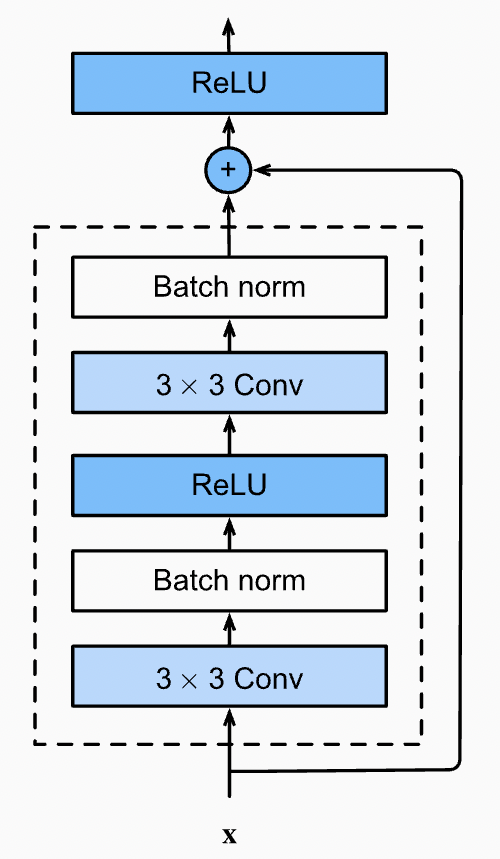

In [ ]:
def identity_block(x, filter):
    # Meng-copy tensor ke variabel bernama x_skip
    x_skip = x

    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)  # Konvolusi dgn ukuran kernel 3x3; mengeluarkan output berukuran sama dgn input
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x) # Konvolusi dgn ukuran kernel 3x3; mengeluarkan output berukuran sama dgn input
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    # Menjumlahkan x dengan residu-nya (x_skip)
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

Convolutional Block

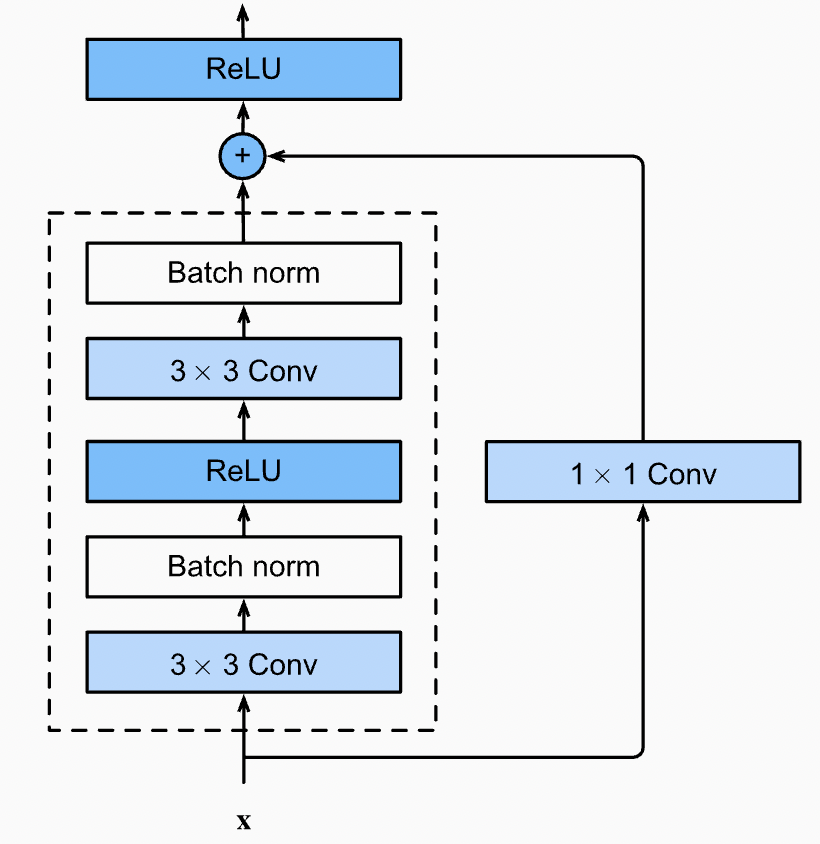

In [ ]:
def convolutional_block(x, filter):
    # Meng-copy tensor ke variabel bernama x_skip
    x_skip = x

    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x) # Konvolusi dgn ukuran kernel 3x3 dan strides sebesar 2 ke kanan dan 2 ke bawah
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)  # Konvolusi dgn ukuran kernel 3x3
    x = tf.keras.layers.BatchNormalization(axis=3)(x)

    # Memproses residu dengan konvolusi 1x1
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)

    # Menjumlahkan x dengan residu-nya (x_skip)
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

ResNet34

In [ ]:
def ResNet34(shape = (100, 100, 3), classes = 4):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)

    # Step 2 (Layer konvolusi awal bersama dengan Maxpool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    # Mendefinisikan ukuran blok dan ukuran awal filter
    block_layers = [3, 4, 6, 3]
    filter_size = 64

    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # Pada blok 1, convolutional_block tidak diperlukan
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # Satu convolutional_block diikuti oleh beberapa identity_block
            # Ukuran filter akan terus bertambah dengan faktor 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
                
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

Compiling and Fitting the Model

In [ ]:
model = ResNet34(shape=(100,100,3))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=25, 
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=len(validation_generator),  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/25
29/29 - 25s - loss: 5.1650 - accuracy: 0.3184 - val_loss: 195263.1719 - val_accuracy: 0.4040 - 25s/epoch - 853ms/step
Epoch 2/25
29/29 - 17s - loss: 1.4299 - accuracy: 0.3936 - val_loss: 11.0868 - val_accuracy: 0.4059 - 17s/epoch - 603ms/step
Epoch 3/25
29/29 - 18s - loss: 1.3932 - accuracy: 0.3950 - val_loss: 1.3276 - val_accuracy: 0.4040 - 18s/epoch - 616ms/step
Epoch 4/25
29/29 - 18s - loss: 1.3420 - accuracy: 0.3981 - val_loss: 1.3289 - val_accuracy: 0.4040 - 18s/epoch - 613ms/step
Epoch 5/25
29/29 - 17s - loss: 1.4091 - accuracy: 0.4012 - val_loss: 1.3158 - val_accuracy: 0.4040 - 17s/epoch - 600ms/step
Epoch 6/25
29/29 - 17s - loss: 1.3641 - accuracy: 0.3874 - val_loss: 1.3297 - val_accuracy: 0.4040 - 17s/epoch - 592ms/step
Epoch 7/25
29/29 - 17s - loss: 1.3138 - accuracy: 0.3961 - val_loss: 1.3237 - val_accuracy: 0.4040 - 17s/epoch - 596ms/step
Epoch 8/25
29/29 - 17s - loss: 1.2922 - accuracy: 0.4151 - val_loss: 1.3179 - val_accuracy: 0.4040 - 17s/epoch - 599ms/step
Ep

Dari *model fitting* di atas, dapat dilihat bahwa model memiliki skor akurasi akhir sebesar 90,54% pada set training. Di lain sisi, model memiliki skor akurasi akhir sebesar 51,09% pada set validation. Hal ini menandakan bahwa model mengalami *overfitting*.

## Plotting the accuracy and loss history of training and validation

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

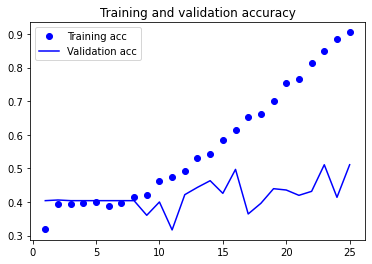

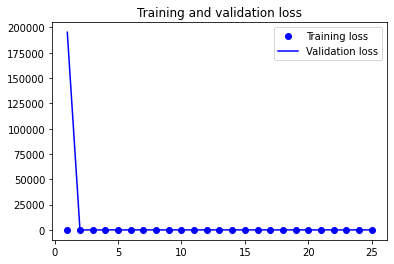

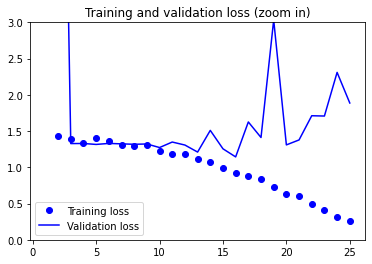

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (zoom in)')
plt.ylim((0,3))
plt.legend()

plt.show()

Seperti yang dapat dilihat pada chart “training and validation accuracy” ini, akurasi pada set training terus meningkat seiring bertambahnya epoch. Namun, akurasi pada set validasi cenderung bersifat fluktuatif.

Hal yang tidak jauh berbeda juga terjadi pada chart “training and validation loss” dimana loss pada set training bisa terus menurun, tetapi loss pada set validasi justru fluktuatif dengan cenderung meningkat setelah epoch ke-14.


## Kesimpulan
Kinerja model masih kurang baik karena model mengalami *overfitting* sehingga hanya memiliki akurasi sebesar 51,09% pada set validasi. Ke depannya, diperlukan *finetuning* lebih lanjut agar model dapat bekerja dengan lebih baik.